In [1]:
import pandas as pd
import psycopg2
import sqlalchemy
from matplotlib import pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
from datetime import date

Holt-Winters Exponential Smoothing is used for forecasting time series data that exhibits both a trend and a seasonal variation.

In [2]:
connection = psycopg2.connect(
    host = 'teamev.c5ap8dqhexya.us-east-1.rds.amazonaws.com',
    port = 5432,
    user = 'postgres',
    password = 'dogecoin',
    database='postgres'
    )
cursor=connection.cursor()

sql = """
SELECT * FROM maclea; 
"""

df = pd.read_sql(sql, con=connection)
# Loading Data
# df = pd.read_sql_table('monthly_sales', con=connection)
# file_path = "<insert_file_path_right_here"
# df = pd.read_csv(file_path)
df.head(10)

,month,total_ev,elec_price,gas_price,model_id_count,brand_id_count,ev_stations
0,2012-01-01,1257.0,0.128,3.380,4,4,2057.0
1,2012-02-01,1566.0,0.128,3.579,4,4,2130.0
2,2012-03-01,3815.0,0.127,3.852,4,4,2213.0
3,2012-04-01,3565.0,0.127,3.900,4,4,2273.0
4,2012-05-01,3367.0,0.129,3.732,5,5,2367.0
5,2012-06-01,2524.0,0.135,3.539,6,6,2439.0
6,2012-07-01,3029.0,0.133,3.439,7,7,2497.0
7,2012-08-01,4686.0,0.133,3.722,7,7,2550.0
8,2012-09-01,5745.0,0.133,3.849,8,7,2576.0
9,2012-10-01,7084.0,0.128,3.746,9,7,2771.0


In [3]:
df.dtypes

month              object
total_ev          float64
elec_price        float64
gas_price         float64
model_id_count      int64
brand_id_count      int64
ev_stations       float64
dtype: object

In [4]:
# Change 'month' datatype to date

df['month']= pd.to_datetime(df['month'])

In [5]:
df = df.sort_values(by=['month'])
df

,month,total_ev,elec_price,gas_price,model_id_count,brand_id_count,ev_stations
96,2011-01-01,0.0,0.125,3.095,0,0,197.0
97,2011-02-01,0.0,0.125,3.211,0,0,211.0
98,2011-03-01,0.0,0.127,3.561,0,0,690.0
99,2011-04-01,0.0,0.127,3.800,0,0,704.0
100,2011-05-01,0.0,0.129,3.906,0,0,743.0
...,...,...,...,...,...,...,...
91,2019-08-01,26455.0,0.139,2.621,40,22,15982.0
92,2019-09-01,31833.0,0.139,2.592,39,22,16600.0
93,2019-10-01,8665.0,0.136,2.627,32,16,16926.0
94,2019-11-01,10180.0,0.133,2.598,30,15,17280.0


In [6]:
df['month'] = df['month'].apply(lambda x: x.strftime("%m-%d-%Y"))
df

,month,total_ev,elec_price,gas_price,model_id_count,brand_id_count,ev_stations
96,01-01-2011,0.0,0.125,3.095,0,0,197.0
97,02-01-2011,0.0,0.125,3.211,0,0,211.0
98,03-01-2011,0.0,0.127,3.561,0,0,690.0
99,04-01-2011,0.0,0.127,3.800,0,0,704.0
100,05-01-2011,0.0,0.129,3.906,0,0,743.0
...,...,...,...,...,...,...,...
91,08-01-2019,26455.0,0.139,2.621,40,22,15982.0
92,09-01-2019,31833.0,0.139,2.592,39,22,16600.0
93,10-01-2019,8665.0,0.136,2.627,32,16,16926.0
94,11-01-2019,10180.0,0.133,2.598,30,15,17280.0


In [7]:
# Set 'month' to be the index

df = df.set_index('month')
df

,total_ev,elec_price,gas_price,model_id_count,brand_id_count,ev_stations
month,,,,,,
01-01-2011,0.0,0.125,3.095,0,0,197.0
02-01-2011,0.0,0.125,3.211,0,0,211.0
03-01-2011,0.0,0.127,3.561,0,0,690.0
04-01-2011,0.0,0.127,3.800,0,0,704.0
05-01-2011,0.0,0.129,3.906,0,0,743.0
...,...,...,...,...,...,...
08-01-2019,26455.0,0.139,2.621,40,22,15982.0
09-01-2019,31833.0,0.139,2.592,39,22,16600.0
10-01-2019,8665.0,0.136,2.627,32,16,16926.0


In [9]:
# Set the index frequency explicitly to Monthly so that statsmodels does not have
# to try to infer it

df.index.freq = 'MS'

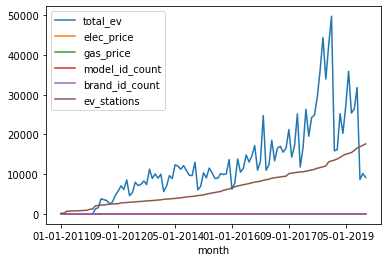

In [10]:
df.plot()
plt.show()

In [8]:
# Split between the training and the test data sets.
# The last 12 periods form the test data.

df_train = df.iloc[:-12]
df_test = df.iloc[-12:]

In [9]:
# Build and train the model on the training data. In the above chart, the level
# of the time series seems to be increasing linearly. So we set the trend as additive.
# However, the seasonal variation around each level seems to be increasing in
# proportion to the current level. So we set the seasonality to multiplicative.

model = HWES(df_train, seasonal_periods=12, trend='add', seasonal='mul')
fitted = model.fit()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).